In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import time
from imblearn.over_sampling import RandomOverSampler
from collections import Counter



from sklearn.metrics import precision_recall_fscore_support 
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB

Using TensorFlow backend.


In [2]:
df = pd.read_json('DiSmldata.json')

In [3]:
#Split into train and test 
X_train, X_test, y_train, y_test = train_test_split(df[['hash_count', 'emoji_count','clean_text',
                                                        'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']], df['label'],test_size =0.20, random_state = 77)

In [4]:
my_stop_words = ENGLISH_STOP_WORDS.union(['disneyland','tokyo','disney', 'im', 'tdrnow','paris','california','amp','disneysea','got',
                                         'ºc', 'ºf', 'ºoº','𝗧𝗵𝗲','くまのプーさん', 'ディズニー', 'ディズニーシー','ディズニーハロウィーン',
                                         'ディズニーランド', 'ディズニー好きと繋がりたい', 'フェスティバルオブミスティーク', 'マルマン',
                                         'ㅋㅋㅋ', '場所', '更新', '月released', '東京ディズニーシー', '東京ディズニーランド', '東京ディズニーリゾート',
                                         '香港迪士尼樂園', 'ºº', 'hong', 'kong',"disneylandresort", "disneyland", "disneyresort",
                                          "californiaadventure",'downtowndisney','disneyanaheim','disneylandanaheim',
                                          'disneycalifornia','californiadisney','disneysea', 'disneytokyo', 'disneytokyoresort', 
                                          'tokyodisney','tokyodisneyresort', 'tokyodisneyland','東京ディズニーランド', 'ディズニーランド',
                                          '東京ディズニーシー', 'ズニーシー', 'tdr_now', 'tdr_md','tdr','dca','dl'])

In [5]:
#min_df and max_df

In [6]:
def make_xy(df, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(df.clean_text)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = df.label
    return X, y
X, y = make_xy(df)

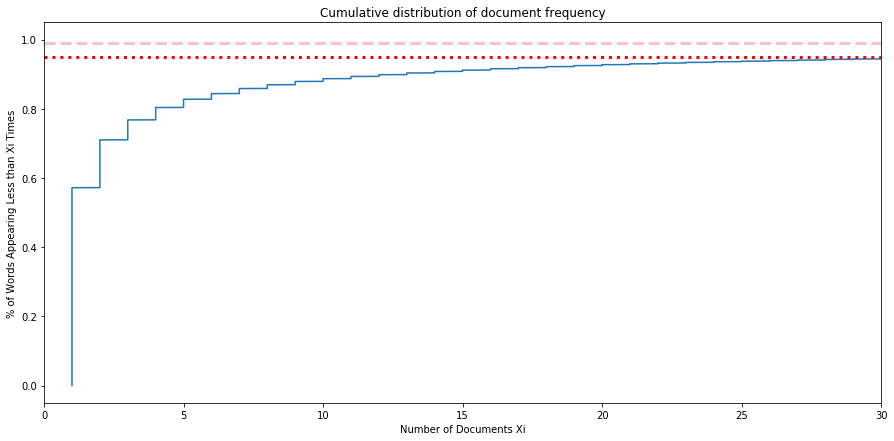

In [7]:
data = np.sum(X>0,axis=0)
sorted_df = np.sort(data).reshape(-1,1)
yvals=np.arange(len(sorted_df))/float(len(sorted_df)-1)
plt.figure(figsize = (15,7))
plt.plot(sorted_df,yvals)
plt.xlim([0,30])
plt.axhline(0.95, c = 'red', linestyle = ':', linewidth = 3)
plt.axhline(0.99, c = 'pink', linestyle = '--', linewidth =3)
plt.xlabel('Number of Documents Xi')
plt.ylabel('% of Words Appearing Less than Xi Times')
plt.title('Cumulative distribution of document frequency')
plt.show()

In [8]:
#Set to 25 max_df 3 min_df and ngram_range = (1,3)

In [9]:
#Count vectorizer Document term matrix

count_vecto = CountVectorizer(stop_words = my_stop_words, min_df = 3, max_df = 25, ngram_range = (1,3))
count_vecto_fit = count_vecto.fit(X_train['clean_text'])

count_train = count_vecto_fit.transform(X_train['clean_text'])
count_test = count_vecto_fit.transform(X_test['clean_text'])

X_train_vect = pd.concat([X_train[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(count_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(count_test.toarray())], axis=1)

In [10]:
X_train_vect.shape

(70008, 37985)

In [11]:
#Balance train Data 
ros = RandomOverSampler(random_state=77)
X_resampled_ros, y_resampled_ros = ros.fit_resample(X_train_vect.values, y_train.values)
print(sorted(Counter(y_resampled_ros).items()))

[(0, 23522), (1, 23522), (2, 23522), (3, 23522), (4, 23522), (5, 23522)]


In [12]:
#Multinomial Bayes

#Instantiate our model 
nb_clf = MultinomialNB(alpha = 0.05)

#Train our Model 
start = time.time()
nb_clf.fit(X_resampled_ros, y_resampled_ros)
end = time.time()
fit_time = (end - start)

#Model Predict 
start = time.time()
y_pred = nb_clf.predict(X_test_vect)
end = time.time()
pred_time = (end - start)

#Model Scoring 
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='macro')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), 
    round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Fit time: 2663.765 / Predict time: 33.033 ---- Precision: 0.52 / Recall: 0.547 / Accuracy: 0.573


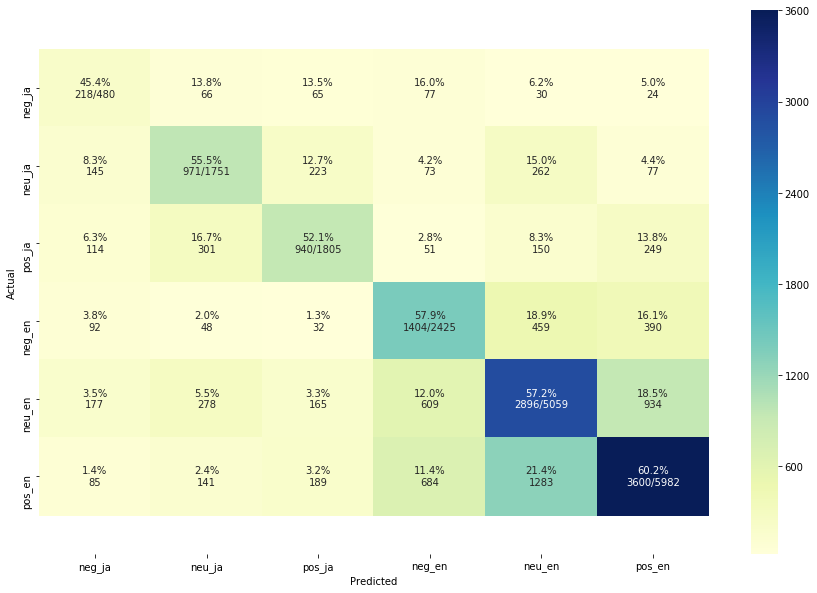

In [13]:
#Confusion matrix 
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred)
class_names = ['neg_ja', 'neu_ja', 'pos_ja', 'neg_en', 'neu_en', 'pos_en']


def plot_cm(y_true, y_pred, figsize=(15,10)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=(15,10))
    ax = sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    
plot_cm(y_test, y_pred)
plt.show()

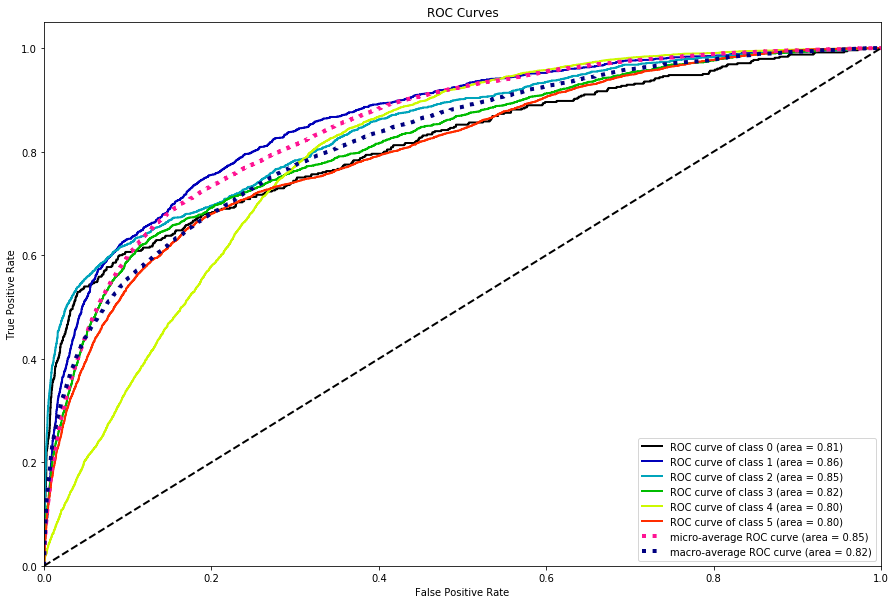

In [15]:
#ROC AUC
import scikitplot as scikitplot #to make things easy
y_pred_proba = nb_clf.predict_proba(X_test_vect)
scikitplot.metrics.plot_roc(y_test, y_pred_proba, figsize=(15,10))
plt.show()

In [17]:
from sklearn.metrics import roc_auc_score

y_prob = nb_clf.predict_proba(X_test_vect)

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.831489 (macro),
0.830312 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.823154 (macro),
0.813845 (weighted by prevalence)


In [ ]:
#Max Features

In [7]:
def nb_feature_num(features, ngram):
    cv = CountVectorizer(stop_words = my_stop_words, max_features = features, ngram_range = ngram)
    cv_fit = cv.fit(X_train['clean_text'])

    cv_train = cv_fit.transform(X_train['clean_text'])
    cv_test = cv_fit.transform(X_test['clean_text'])

    X_train_vect = pd.concat([X_train[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                           'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                           'tweet_len','cap_count']].reset_index(drop=True), 
               pd.DataFrame(cv_train.toarray())], axis=1)
    X_test_vect = pd.concat([X_test[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                           'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                           'tweet_len','cap_count']].reset_index(drop=True), 
               pd.DataFrame(cv_test.toarray())], axis=1)
    #Balance
    ros = RandomOverSampler(random_state=77)
    X_resampled_ros, y_resampled_ros = ros.fit_resample(X_train_vect.values, y_train.values)

    #Instantiate our model 
    nb_clf = MultinomialNB(alpha = 0.05)

    #Train our Model 
    start = time.time()
    nb_clf.fit(X_resampled_ros, y_resampled_ros)
    end = time.time()
    fit_time = (end - start)

    #Model Predict 
    start = time.time()
    y_pred = nb_clf.predict(X_test_vect)
    end = time.time()
    pred_time = (end - start)

    #Model Scoring 
    precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='macro')
    print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
        round(fit_time, 3), round(pred_time, 3), round(precision, 3), 
        round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

In [27]:
#Count vectorizer Document term matrix
#Count vectorizer Document term matrix of 3000

count_vecto = CountVectorizer(stop_words = my_stop_words, max_features = 37900, ngram_range = (1,3))
count_vecto_fit = count_vecto.fit(X_train['clean_text'])

count_train = count_vecto_fit.transform(X_train['clean_text'])
count_test = count_vecto_fit.transform(X_test['clean_text'])

X_train_vect = pd.concat([X_train[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(count_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(count_test.toarray())], axis=1)

#Balance train Data 
ros = RandomOverSampler(random_state=77)
X_resampled_ros, y_resampled_ros = ros.fit_resample(X_train_vect.values, y_train.values)
print(sorted(Counter(y_resampled_ros).items()))

[(0, 23522), (1, 23522), (2, 23522), (3, 23522), (4, 23522), (5, 23522)]


In [28]:
#Multinomial Bayes

#Instantiate our model 
nb_clf = MultinomialNB(alpha = 0.05)

#Train our Model 
start = time.time()
nb_clf.fit(X_resampled_ros, y_resampled_ros)
end = time.time()
fit_time = (end - start)

#Model Predict 
start = time.time()
y_pred = nb_clf.predict(X_test_vect)
end = time.time()
pred_time = (end - start)

#Model Scoring 
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='macro')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), 
    round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Fit time: 2371.863 / Predict time: 34.725 ---- Precision: 0.645 / Recall: 0.664 / Accuracy: 0.7


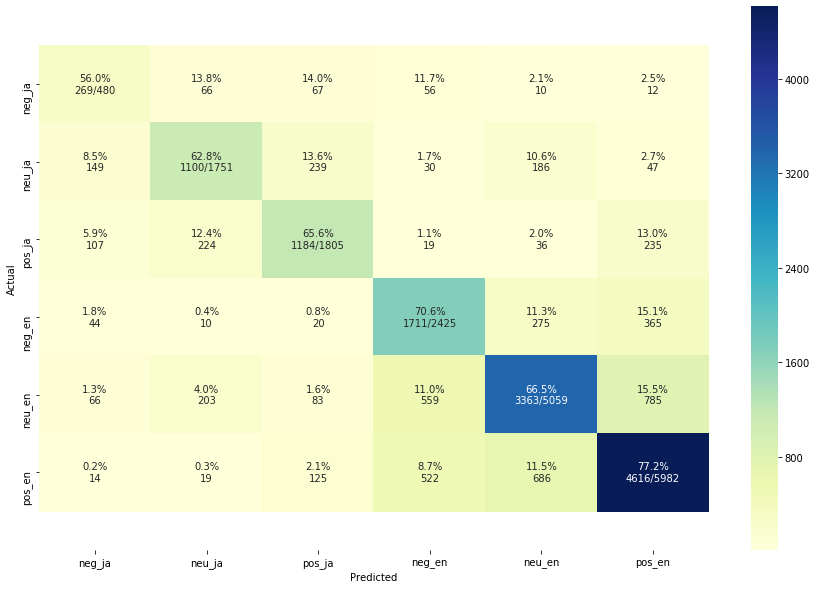

In [29]:
#Confusion matrix 
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred)
class_names = ['neg_ja', 'neu_ja', 'pos_ja', 'neg_en', 'neu_en', 'pos_en']


def plot_cm(y_true, y_pred, figsize=(15,10)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=(15,10))
    ax = sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    
plot_cm(y_test, y_pred)
plt.show()

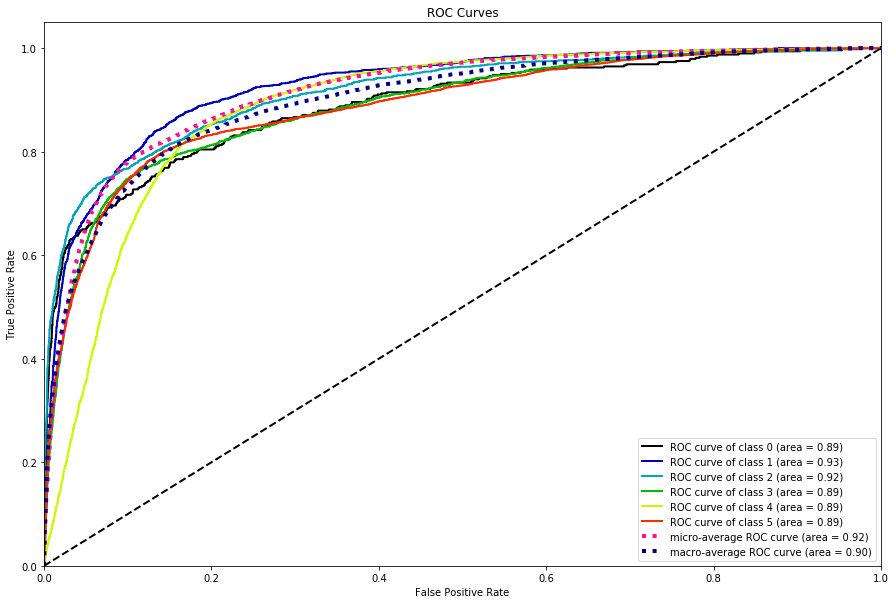

In [30]:
#ROC AUC
import scikitplot as scikitplot #to make things easy
y_pred_proba = nb_clf.predict_proba(X_test_vect)
scikitplot.metrics.plot_roc(y_test, y_pred_proba, figsize=(15,10))
plt.show()

In [31]:
from sklearn.metrics import roc_auc_score

y_prob = nb_clf.predict_proba(X_test_vect)

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.901202 (macro),
0.904067 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.899604 (macro),
0.894852 (weighted by prevalence)


In [ ]:
#Testing out different Max Features

In [10]:
#Count vectorizer Document term matrix of 3000

count_vecto = CountVectorizer(stop_words = my_stop_words, max_features = 3000, ngram_range = (1,3))
count_vecto_fit = count_vecto.fit(X_train['clean_text'])

count_train = count_vecto_fit.transform(X_train['clean_text'])
count_test = count_vecto_fit.transform(X_test['clean_text'])

X_train_vect = pd.concat([X_train[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(count_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(count_test.toarray())], axis=1)

#Balance train Data 
ros = RandomOverSampler(random_state=77)
X_resampled_ros, y_resampled_ros = ros.fit_resample(X_train_vect.values, y_train.values)
print(sorted(Counter(y_resampled_ros).items()))

[(0, 23522), (1, 23522), (2, 23522), (3, 23522), (4, 23522), (5, 23522)]


In [11]:
#Multinomial Bayes

#Instantiate our model 
nb_clf = MultinomialNB(alpha = 0.05)

#Train our Model 
start = time.time()
nb_clf.fit(X_resampled_ros, y_resampled_ros)
end = time.time()
fit_time = (end - start)

#Model Predict 
start = time.time()
y_pred = nb_clf.predict(X_test_vect)
end = time.time()
pred_time = (end - start)

#Model Scoring 
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='macro')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), 
    round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Fit time: 73.09 / Predict time: 1.15 ---- Precision: 0.58 / Recall: 0.637 / Accuracy: 0.651


In [15]:
#Count vectorizer Document term matrix of 5000

count_vecto = CountVectorizer(stop_words = my_stop_words, max_features = 5000, ngram_range = (1,3))
count_vecto_fit = count_vecto.fit(X_train['clean_text'])

count_train = count_vecto_fit.transform(X_train['clean_text'])
count_test = count_vecto_fit.transform(X_test['clean_text'])

X_train_vect = pd.concat([X_train[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(count_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(count_test.toarray())], axis=1)

#Balance train Data 
ros = RandomOverSampler(random_state=77)
X_resampled_ros, y_resampled_ros = ros.fit_resample(X_train_vect.values, y_train.values)
print(sorted(Counter(y_resampled_ros).items()))

[(0, 23522), (1, 23522), (2, 23522), (3, 23522), (4, 23522), (5, 23522)]


In [16]:
#Multinomial Bayes

#Instantiate our model 
nb_clf = MultinomialNB(alpha = 0.05)

#Train our Model 
start = time.time()
nb_clf.fit(X_resampled_ros, y_resampled_ros)
end = time.time()
fit_time = (end - start)

#Model Predict 
start = time.time()
y_pred = nb_clf.predict(X_test_vect)
end = time.time()
pred_time = (end - start)

#Model Scoring 
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='macro')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), 
    round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Fit time: 124.431 / Predict time: 2.176 ---- Precision: 0.602 / Recall: 0.651 / Accuracy: 0.669


In [17]:
#Count vectorizer Document term matrix of 7000 

count_vecto = CountVectorizer(stop_words = my_stop_words, max_features = 7000, ngram_range = (1,3))
count_vecto_fit = count_vecto.fit(X_train['clean_text'])

count_train = count_vecto_fit.transform(X_train['clean_text'])
count_test = count_vecto_fit.transform(X_test['clean_text'])

X_train_vect = pd.concat([X_train[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(count_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(count_test.toarray())], axis=1)

#Balance train Data 
ros = RandomOverSampler(random_state=77)
X_resampled_ros, y_resampled_ros = ros.fit_resample(X_train_vect.values, y_train.values)
print(sorted(Counter(y_resampled_ros).items()))

[(0, 23522), (1, 23522), (2, 23522), (3, 23522), (4, 23522), (5, 23522)]


In [18]:
#Multinomial Bayes

#Instantiate our model 
nb_clf = MultinomialNB(alpha = 0.05)

#Train our Model 
start = time.time()
nb_clf.fit(X_resampled_ros, y_resampled_ros)
end = time.time()
fit_time = (end - start)

#Model Predict 
start = time.time()
y_pred = nb_clf.predict(X_test_vect)
end = time.time()
pred_time = (end - start)

#Model Scoring 
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='macro')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), 
    round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Fit time: 219.038 / Predict time: 3.994 ---- Precision: 0.616 / Recall: 0.66 / Accuracy: 0.679


In [19]:
#Count vectorizer Document term matrix of 10000

count_vecto = CountVectorizer(stop_words = my_stop_words, max_features = 10000, ngram_range = (1,3))
count_vecto_fit = count_vecto.fit(X_train['clean_text'])

count_train = count_vecto_fit.transform(X_train['clean_text'])
count_test = count_vecto_fit.transform(X_test['clean_text'])

X_train_vect = pd.concat([X_train[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(count_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(count_test.toarray())], axis=1)

#Balance train Data 
ros = RandomOverSampler(random_state=77)
X_resampled_ros, y_resampled_ros = ros.fit_resample(X_train_vect.values, y_train.values)
print(sorted(Counter(y_resampled_ros).items()))

[(0, 23522), (1, 23522), (2, 23522), (3, 23522), (4, 23522), (5, 23522)]


In [20]:
#Multinomial Bayes

#Instantiate our model 
nb_clf = MultinomialNB(alpha = 0.05)

#Train our Model 
start = time.time()
nb_clf.fit(X_resampled_ros, y_resampled_ros)
end = time.time()
fit_time = (end - start)

#Model Predict 
start = time.time()
y_pred = nb_clf.predict(X_test_vect)
end = time.time()
pred_time = (end - start)

#Model Scoring 
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='macro')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), 
    round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Fit time: 417.243 / Predict time: 5.948 ---- Precision: 0.626 / Recall: 0.666 / Accuracy: 0.687


In [21]:
#Count vectorizer Document term matrix of 15000

count_vecto = CountVectorizer(stop_words = my_stop_words, max_features = 15000, ngram_range = (1,3))
count_vecto_fit = count_vecto.fit(X_train['clean_text'])

count_train = count_vecto_fit.transform(X_train['clean_text'])
count_test = count_vecto_fit.transform(X_test['clean_text'])

X_train_vect = pd.concat([X_train[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(count_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(count_test.toarray())], axis=1)

#Balance train Data 
ros = RandomOverSampler(random_state=77)
X_resampled_ros, y_resampled_ros = ros.fit_resample(X_train_vect.values, y_train.values)
print(sorted(Counter(y_resampled_ros).items()))

[(0, 23522), (1, 23522), (2, 23522), (3, 23522), (4, 23522), (5, 23522)]


In [22]:
#Multinomial Bayes

#Instantiate our model 
nb_clf = MultinomialNB(alpha = 0.05)

#Train our Model 
start = time.time()
nb_clf.fit(X_resampled_ros, y_resampled_ros)
end = time.time()
fit_time = (end - start)

#Model Predict 
start = time.time()
y_pred = nb_clf.predict(X_test_vect)
end = time.time()
pred_time = (end - start)

#Model Scoring 
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='macro')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), 
    round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Fit time: 785.498 / Predict time: 8.91 ---- Precision: 0.635 / Recall: 0.668 / Accuracy: 0.694


In [23]:
#Count vectorizer Document term matrix of 20000

count_vecto = CountVectorizer(stop_words = my_stop_words, max_features = 20000, ngram_range = (1,3))
count_vecto_fit = count_vecto.fit(X_train['clean_text'])

count_train = count_vecto_fit.transform(X_train['clean_text'])
count_test = count_vecto_fit.transform(X_test['clean_text'])

X_train_vect = pd.concat([X_train[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(count_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(count_test.toarray())], axis=1)

#Balance train Data 
ros = RandomOverSampler(random_state=77)
X_resampled_ros, y_resampled_ros = ros.fit_resample(X_train_vect.values, y_train.values)
print(sorted(Counter(y_resampled_ros).items()))

[(0, 23522), (1, 23522), (2, 23522), (3, 23522), (4, 23522), (5, 23522)]


In [24]:
#Multinomial Bayes

#Instantiate our model 
nb_clf = MultinomialNB(alpha = 0.05)

#Train our Model 
start = time.time()
nb_clf.fit(X_resampled_ros, y_resampled_ros)
end = time.time()
fit_time = (end - start)

#Model Predict 
start = time.time()
y_pred = nb_clf.predict(X_test_vect)
end = time.time()
pred_time = (end - start)

#Model Scoring 
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='macro')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), 
    round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Fit time: 1283.223 / Predict time: 13.754 ---- Precision: 0.637 / Recall: 0.665 / Accuracy: 0.695


In [ ]:
# Fit time: 73.09 / Predict time: 1.15 ---- Precision: 0.58 / Recall: 0.637 / Accuracy: 0.651
# Fit time: 124.431 / Predict time: 2.176 ---- Precision: 0.602 / Recall: 0.651 / Accuracy: 0.669
# Fit time: 219.038 / Predict time: 3.994 ---- Precision: 0.616 / Recall: 0.66 / Accuracy: 0.679
# Fit time: 417.243 / Predict time: 5.948 ---- Precision: 0.626 / Recall: 0.666 / Accuracy: 0.687
# Fit time: 785.498 / Predict time: 8.91 ---- Precision: 0.635 / Recall: 0.668 / Accuracy: 0.694
# Fit time: 1283.223 / Predict time: 13.754 ---- Precision: 0.637 / Recall: 0.665 / Accuracy: 0.695
#Fit time: 2371.863 / Predict time: 34.725 ---- Precision: 0.645 / Recall: 0.664 / Accuracy: 0.7

In [32]:
nb_table = pd.DataFrame()
nb_table['train_time'] = [73.09, 124.431, 219.038, 417.243, 785.498, 1283.223, 2371.863]
nb_table['features'] = [3000, 5000, 7000, 10000, 15000, 20000, 37900]
nb_table['accuracy_score'] = [0.651, 0.669, 0.679, 0.687, 0.694, 0.695, 0.7]
nb_table['precision'] = [0.58, 0.602, 0.616, 0.626, 0.635, 0.637, 0.645]
nb_table['recall'] = [0.637, 0.651, 0.66, 0.666, 0.668, 0.665, 0.664]

In [33]:
nb_table

,train_time,features,accuracy_score,precision,recall
0,73.090,3000,0.651,0.580,0.637
1,124.431,5000,0.669,0.602,0.651
2,219.038,7000,0.679,0.616,0.660
3,417.243,10000,0.687,0.626,0.666
4,785.498,15000,0.694,0.635,0.668
5,1283.223,20000,0.695,0.637,0.665
6,2371.863,37900,0.700,0.645,0.664


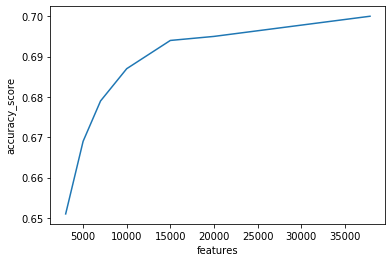

In [35]:
sns.lineplot(nb_table['features'], nb_table['accuracy_score'])
plt.show()

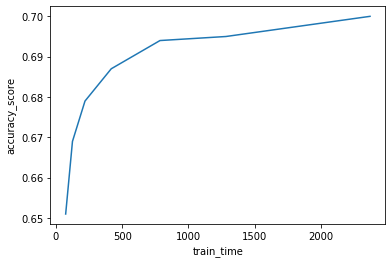

In [36]:
sns.lineplot(nb_table['train_time'], nb_table['accuracy_score'])
plt.show()

In [ ]:
#Around 15000 features for (1,3) ngrams 

In [37]:
#Count vectorizer Document term matrix of 15000

count_vecto = CountVectorizer(stop_words = my_stop_words, max_features = 15000, ngram_range = (1,3))
count_vecto_fit = count_vecto.fit(X_train['clean_text'])

count_train = count_vecto_fit.transform(X_train['clean_text'])
count_test = count_vecto_fit.transform(X_test['clean_text'])

X_train_vect = pd.concat([X_train[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(count_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(count_test.toarray())], axis=1)

#Balance train Data 
ros = RandomOverSampler(random_state=77)
X_resampled_ros, y_resampled_ros = ros.fit_resample(X_train_vect.values, y_train.values)
print(sorted(Counter(y_resampled_ros).items()))

[(0, 23522), (1, 23522), (2, 23522), (3, 23522), (4, 23522), (5, 23522)]


In [38]:
#Multinomial Bayes

#Instantiate our model 
nb_clf = MultinomialNB(alpha = 0.05)

#Train our Model 
start = time.time()
nb_clf.fit(X_resampled_ros, y_resampled_ros)
end = time.time()
fit_time = (end - start)

#Model Predict 
start = time.time()
y_pred = nb_clf.predict(X_test_vect)
end = time.time()
pred_time = (end - start)

#Model Scoring 
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='macro')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), 
    round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Fit time: 763.818 / Predict time: 8.39 ---- Precision: 0.635 / Recall: 0.668 / Accuracy: 0.694


In [39]:
from sklearn.metrics import classification_report
target_names = ['ja_neg', 'ja_neu', 'ja_pos', 'en_neg', 'en_neu', 'en_pos']
print(classification_report(y_test,y_pred, target_names = target_names))

              precision    recall  f1-score   support

      ja_neg       0.39      0.60      0.47       480
      ja_neu       0.64      0.64      0.64      1751
      ja_pos       0.68      0.64      0.66      1805
      en_neg       0.59      0.72      0.65      2425
      en_neu       0.73      0.66      0.69      5059
      en_pos       0.77      0.76      0.77      5982

    accuracy                           0.69     17502
   macro avg       0.63      0.67      0.65     17502
weighted avg       0.70      0.69      0.70     17502



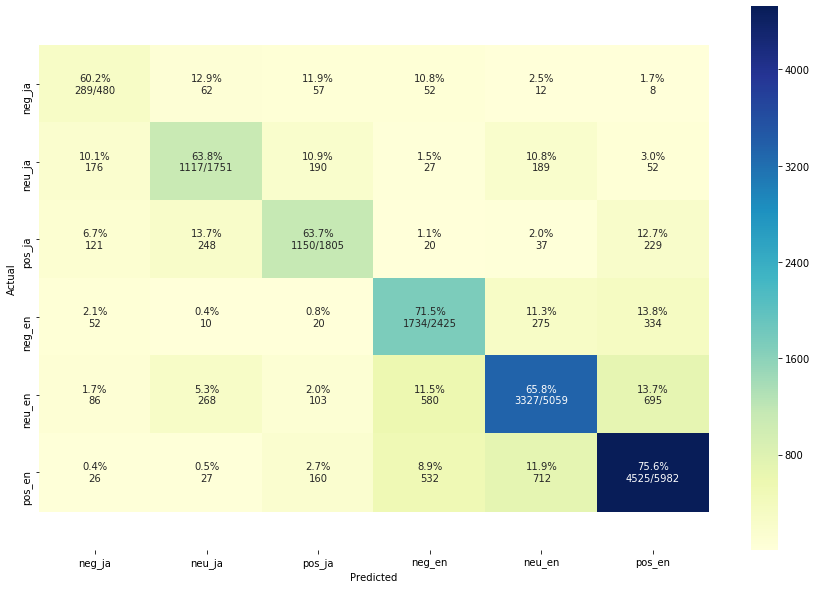

In [40]:
#Confusion matrix 
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred)
class_names = ['neg_ja', 'neu_ja', 'pos_ja', 'neg_en', 'neu_en', 'pos_en']


def plot_cm(y_true, y_pred, figsize=(15,10)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=(15,10))
    ax = sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    
plot_cm(y_test, y_pred)
plt.show()

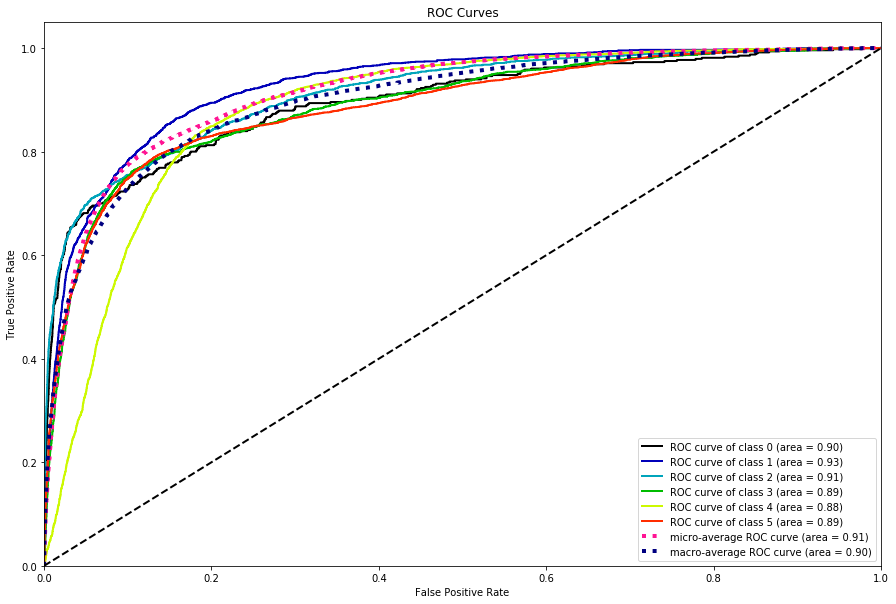

In [41]:
#ROC AUC
import scikitplot as scikitplot #to make things easy
y_pred_proba = nb_clf.predict_proba(X_test_vect)
scikitplot.metrics.plot_roc(y_test, y_pred_proba, figsize=(15,10))
plt.show()

In [42]:
from sklearn.metrics import roc_auc_score

y_prob = nb_clf.predict_proba(X_test_vect)

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.901938 (macro),
0.904090 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.899631 (macro),
0.893888 (weighted by prevalence)
